# Simulation studies

In [61]:
%matplotlib inline
from aesthetics import params
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import numpy as np
from numpy.linalg import det, inv
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, mutual_info_score
import pandas as pd
from itca.simulation_suites import *
from itca.metrics import adjusted_accuracy_score, prediction_entropy, itca
from itca.utils import eval_metrics, bidict, compute_y_dist
mpl.rcParams.update(params)

In [2]:
# definition of CKL
def gaussian_kl(mu1, mu2, S1, S2, epsilon=0):
    """
    Compute the kl divergence between two Gaussian distributions.
    mu1: (n_features, )
    """
    n_features = mu1.size
    I = np.eye(n_features)
    S2_ = S2 + I * epsilon
    S1_ = S1 + I * epsilon
    diff = mu1 - mu2
    invS2_ = inv(S2_)
    kl = 0.5 * np.log(det(S2_) / det(S1_)) + \
          0.5 * np.trace(invS2_.dot(S1)) + 0.5 * diff.T.dot(invS2_).dot(diff) - 0.5 * n_features
    return kl

def log_gaussian_prod(mu1, mu2, S1, S2, epsilon=1e-3):
    n_features = mu1.size
    I = np.eye(n_features)
    S_sum_ = S1 + S2 + epsilon * I
    diff = mu1 - mu2
    logt = -0.5 * n_features * np.log(math.pi * 2) - 0.5 * np.log(det(S_sum_) + 1e-10) - \
           0.5 * diff.dot(inv(S_sum_)).dot(diff)
    return logt

def gaussian_entropy(mu, S, epsilon = 0):
    n_features = mu.size
    S_ = np.eye(n_features) * epsilon + S
    return 0.5 * np.log(det(2 * math.pi * math.e * S_) + 1e-10)

def gm_kl_lb(m1, m2, epsilon = 0):
    """
    Compute the kl divergence lower bound between two Gaussian mixture models.
    m1: dict {"p": [p1, p2, .., pK], "mu": [mu1, mu2, ..., muK], "S"： [S1, S2, ..., SK]}
    """
    K = len(m1["p"])
    K_ = len(m2["p"])
    lb = 0
    for i in range(K):
        num = 0
        for l in range(K):
            num += m1["p"][l] * np.exp(-gaussian_kl(m1["mu"][i], m1["mu"][l], m1["S"][i], m1["S"][l]))
        den = 0
        for j in range(K_):
            logt_ij = log_gaussian_prod(m1["mu"][i], m2["mu"][j], m1["S"][i], m2["S"][j], epsilon=epsilon)
            den += m2["p"][j] * np.exp(logt_ij)
        
        lb += m1["p"][i] * np.log(num / den)
        lb -= m1["p"][i] * gaussian_entropy(m1["mu"][i], m1["S"][i])
    return lb
 
def gm_kl_ub(m1, m2, epsilon=0):
    K = len(m1["p"])
    K_ = len(m2["p"])
    ub = 0
    for i in range(K):
        num = 0
        for l in range(K):
            logt_il = log_gaussian_prod(m1["mu"][i], m1["mu"][l], m1["S"][i], m1["S"][l], epsilon=epsilon)
            num += m1["p"][l] * np.exp(logt_il)
        den = 0
        for j in range(K_):
            den += m2["p"][j] * np.exp(-gaussian_kl(m1["mu"][i], m2["mu"][j], m1["S"][i], m2["S"][j]))
        ub += m1["p"][i] * np.log(num / den) + m1["p"][i] * gaussian_entropy(m1["mu"][i], m1["S"][i])
    return ub
def gm_kl_mean(m1, m2):
    return (gm_kl_ub(m1, m2) + gm_kl_lb(m1, m2)) * .5

def compute_mixture_gaussian(X, y, epsilon=0):
    m = {"p": [], "mu": [], "S": []}
    labels, counts = np.unique(y, return_counts=True)
    total = np.sum(counts)
    eI = np.eye(X.shape[1]) * epsilon
    for ind, label in enumerate(labels):
        if counts[ind] > 2:
            m["p"].append(counts[ind] / total)
            sub_X = X[y==label, :]
            mu = np.mean(sub_X, axis=0)
            S = (sub_X - mu).T.dot(sub_X - mu) / (sub_X.shape[0] - 1) + eI
            m["S"].append(S)
            m["mu"].append(mu)
    return m

def klkl(X, y, mappping, clf, epsilon=0):
    """
    Compute the competive measure without cross-validation.
    """
    clf.fit(X, mapping.map(y))
    y_pred = clf.predict(X)
    f_y_pred = compute_mixture_gaussian(X, y_pred, epsilon=epsilon)
    f_ty = compute_mixture_gaussian(X, mapping.map(y), epsilon=epsilon)
    kl1 = gm_kl_mean(f_y_pred, f_ty)
    f_y = compute_mixture_gaussian(X, y, epsilon=epsilon)
    kl2 = gm_kl_mean(f_y_pred, f_y)
    return kl1 + kl2
# def wrapper_mi(y_true, y_pred, mapping, y_dist):
def klkl_factory(X):
    def klkl_wrapper(y_true, y_pred, mapping, y_dist, epsilon=0):
        f_y_pred = compute_mixture_gaussian(X, y_pred, epsilon=epsilon)
        f_ty = compute_mixture_gaussian(X, mapping.map(y_true), epsilon=epsilon)
        kl1 = gm_kl_mean(f_y_pred, f_ty)
        f_y = compute_mixture_gaussian(X, y_true, epsilon=epsilon)
        kl2 = gm_kl_mean(f_y_pred, f_y)
        return -kl1 - kl2
    return klkl_wrapper

In [3]:
def wrapper_aac(y_true, y_pred, mapping, y_dist):
    return adjusted_accuracy_score(y_true, y_pred, mapping, adjust_by="size")


def wrapper_ckl(X, y_true, y_pred, mapping, y_dist, epsilon=1e-4):
    f_y_pred = compute_mixture_gaussian(X, y_pred, epsilon=epsilon)
    f_ty = compute_mixture_gaussian(X, mapping.map(y_true), epsilon=epsilon)
    kl1 = gm_kl_mean(f_y_pred, f_ty)
    f_y = compute_mixture_gaussian(X, y_true, epsilon=epsilon)
    kl2 = gm_kl_mean(f_y_pred, f_y)
    return -kl1 - kl2


def wrapper_mi(y_true, y_pred, mapping, y_dist):
    return mutual_info_score(y_true, y_pred)


def wrapper_acc(y_true, y_pred, mapping, y_dist):
    return accuracy_score(mapping.map(y_true), y_pred)

## Figure 2: Comparison of ITCA and five other criteria using LDA

In [8]:
from itca.utils import int2mapping

metrics = {"ACC": wrapper_acc, 
           "MI": wrapper_mi,
           "AAC":wrapper_aac,
           "CKL": wrapper_ckl,
           "PE": prediction_entropy, 
           "ITCA": itca}

observed_classes = 6
ints = list(range(1, 2**(observed_classes-1)))
mappings = [int2mapping(observed_classes, i) for i in ints]
mappings.reverse()  
n_classes = [len(mapping.inverse) for mapping in mappings]
lda = LinearDiscriminantAnalysis()
metric_names = list(metrics.keys())

In [11]:
true_ind = 10
true_mapping = int2mapping(6, true_ind)
print("True combination: ", true_mapping.inverse)
sim1 = lda_suite(length=1.5, p=2, n_classes=len(true_mapping.inverse), n=2000)
sim1_obs = SimData(sim1.generator_name, sim1.X, true_mapping.reverse_map(sim1.y))
true_ind = 2**(observed_classes - 1) - 1 - true_ind
res = []
for mapping in mappings:
    res.append(eval_metrics(sim1_obs.X.T, sim1_obs.y, mapping, lda, metrics))
metric_res = [[] for i in range(len(metrics))]
for d in res:
    for i, metric_name in enumerate(d):
        metric_res[i].append(np.mean(d[metric_name]))

True combination:  {0: [0, 1], 1: [2, 3], 2: [4, 5]}


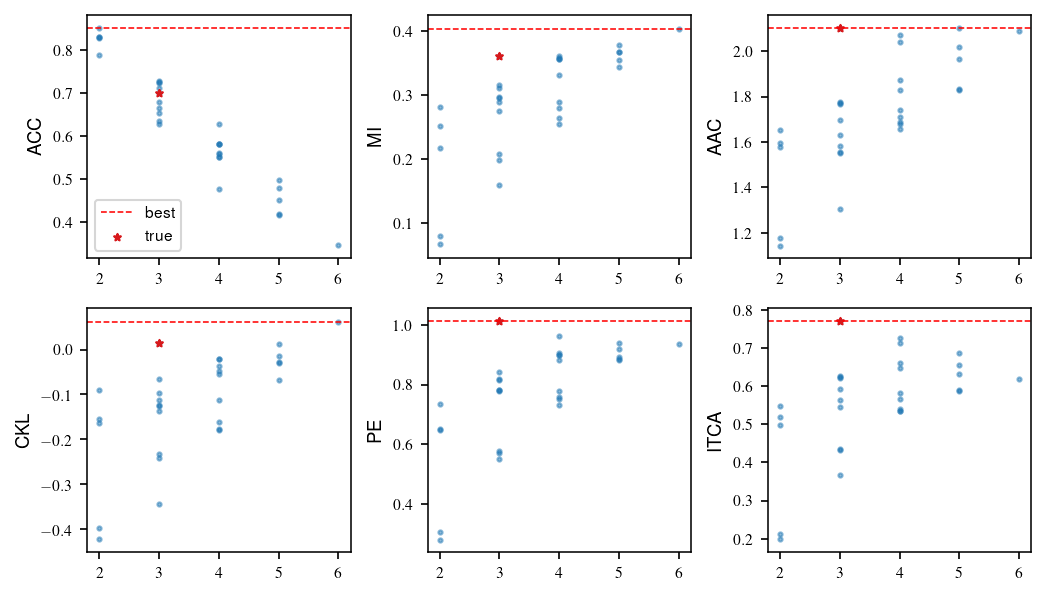

In [19]:
#=========================== Generate Figure 2 =========================================
marker_size = 12
ncols = 3
fig, axes = plt.subplots(2, ncols, dpi=150)
for  ind in range(2 * ncols):
    metric_name = metric_names[ind]
    ax = axes[ind // ncols, ind % ncols]
    df = pd.DataFrame({"nc": n_classes[:true_ind-1] + n_classes[true_ind:],
                       metric_name: metric_res[ind][:true_ind-1] + metric_res[ind][true_ind:], })

    # sns.swarmplot(x="nc", y=metric_name, data=df, color="#1F77B4", size=marker_size * .3, alpha=.5, ax=ax) 
    ax.scatter(n_classes[:true_ind-1] + n_classes[true_ind:], 
               metric_res[ind][:true_ind-1] + metric_res[ind][true_ind:], 
               color="#1F77B4", alpha=0.5)
    best = np.max(metric_res[ind])
    ax.axhline(best, ls='--', color='r', label="best")
    ax.scatter([n_classes[true_ind]], [metric_res[ind][true_ind]], marker='*', color = "#d7191c", s = marker_size, label="true")
    if ax_ind > ncols - 1:
        ax.set_xlabel("$K$")
    ax.set_ylabel(metric_name)
    if ind == 0:
        ax.legend(loc="lower left")
axes[0, 2].set_ylabel("AAC")
fig.set_size_inches(7, 4)
plt.tight_layout()

## Table 2: The performance of six criteria on the 31 simulated datasets with $K_0=6$

In [5]:
from itca.utils import compute_hamming_distance, int2bvstr

def compute_hamming_dist(true_ind, pred_ind, n_classes, inverse=True):
    if inverse:
        n = 2**(n_classes -1) - 1
        return compute_hamming_distance(int2bvstr(n_classes, n - true_ind), int2bvstr(n_classes, n - pred_ind))
    else:
        return compute_hamming_distance(int2bvstr(n_classes, true_ind), int2bvstr(n_classes, pred_ind))
    

def exhaustive_search(n_classes, clf, metrics, p=4, length=3, n=2000):
    """
    Help functions for exhaustive search.
    """
    hamming_dists = [[] for i in range(len(metrics))]
    ints = list(range(1, 2**(n_classes-1)))
    mappings = [int2mapping(n_classes, i) for i in ints]
    mappings.reverse() 
    for true_ind in range(1, 2**(n_classes -1)):
        true_mapping = int2mapping(n_classes, true_ind)
        sim1 = lda_suite(length=length, p=p, n_classes=len(true_mapping.inverse), n=2000, min_dist=1.5)
        sim1_obs = SimData(sim1.generator_name, sim1.X, true_mapping.reverse_map(sim1.y))
        true_ind = 2**(n_classes - 1) - 1 - true_ind
        res = []
        for mapping in mappings:
            res.append(eval_metrics(sim1_obs.X.T, sim1_obs.y, mapping, clf, metrics))
        metric_res = [[] for i in range(len(metrics))]
        for d in res:
            for i, metric_name in enumerate(d):
                metric_res[i].append(np.mean(d[metric_name]))
        for ind in range(len(metrics)):
            pred_ind = np.argmax(metric_res[ind])
            hamming_dists[ind].append(compute_hamming_dist(true_ind, pred_ind, n_classes))
    return hamming_dists

In [16]:
np.seterr(all="ignore")
n_classes = 6
hamming_dists_lda = exhaustive_search(n_classes, lda, metrics, length=2)

In [15]:
rf = RandomForestClassifier()
np.seterr(all="ignore")
hamming_dists_rf = exhaustive_search(n_classes, rf, metrics, length=2)

In [17]:
#=========================== print out tables =======================================
#===================== Table 2 ====================================================== 
print("===========LDA===============")
print("Metric& Success & Avg & Max")
for i, metric_name in enumerate(metric_names):
    dist = np.array(hamming_dists_lda[i])
    print("{}&{}/31&{:.2f}&{}\\\\".format(metric_name, np.sum(dist < 1e-5), np.mean(dist), np.max(dist)))
print("===========RF=================")
print("Metric& Success & Avg & Max")
for i, metric_name in enumerate(metric_names):
    dist = np.array(hamming_dists_rf[i])
    print("{}&{}/31&{:.2f}&{}\\\\".format(metric_name, np.sum(dist < 1e-5), np.mean(dist), np.max(dist)))

===========LDA===============
Metric& Success & Avg & Max
ACC&1/31&2.03&4\\
MI&8/31&1.42&4\\
AAC&9/31&1.03&3\\
CKL&8/31&2.29&5\\
PE&22/31&0.55&3\\
ITCA&26/31&0.23&2\\
===========RF=================
Metric& Success & Avg & Max
ACC&1/31&2.03&4\\
MI&6/31&1.65&4\\
AAC&11/31&1.00&3\\
CKL&1/31&2.13&4\\
PE&22/31&0.42&3\\
ITCA&26/31&0.19&2\\


## Table 3: The performance of six criteria on the 127 simulated datasets with $K_0=6$

In [18]:
# It takes ~20 minutes  
n_classes = 8
hamming_dists_lda = exhaustive_search(n_classes, lda, metrics, length=3, p=5, n=500 * n_classes)

In [19]:
print("===========LDA===============")
print("Metric& Success & Avg & Max")
for i, metric_name in enumerate(metric_names):
    dist = np.array(hamming_dists_lda[i])
    print("{}&{}/127&{:.2f}&{}\\\\".format(metric_name, np.sum(dist < 1e-5), np.mean(dist), np.max(dist)))

===========LDA===============
Metric& Success & Avg & Max
ACC&6/127&2.54&6\\
MI&14/127&2.42&6\\
AAC&20/127&1.87&6\\
CKL&1/127&3.54&6\\
PE&103/127&0.44&4\\
ITCA&120/127&0.13&3\\


In [9]:
# It takes ~5 hours on a laptop
n_classes = 8
rf = RandomForestClassifier()
hamming_dists_rf = exhaustive_search(n_classes, rf, metrics, length=3, p=5, n=500 * n_classes)

In [10]:
print("===========RF=================")
print("Metric& Success & Avg & Max")
for i, metric_name in enumerate(metric_names):
    dist = np.array(hamming_dists_rf[i])
    print("{}&{}/127&{:.2f}&{}\\\\".format(metric_name, np.sum(dist < 1e-5), np.mean(dist), np.max(dist)))   

===========RF=================
Metric& Success & Avg & Max
ACC&5/127&2.56&6\\
MI&16/127&2.20&6\\
AAC&10/127&1.90&5\\
CKL&13/127&2.90&6\\
PE&97/127&0.46&4\\
ITCA&119/127&0.10&2\\


## Table 4: Performance of ITCA using five search strategies and LDA on the $31$ simulated datasets with $K_0 = 6$

In [51]:
from itca import GreedySearch, GreedySearchPruned, BFSearch, BFSearchPruned
from tqdm import tqdm
def eval_stragtegies(n_classes, clf, strategies, true_inds = None, **args):
    """
    Help function that helps evaluate strategies
    """
    res = [{"target": [],  "found": [], "counter": [], "path": []} for _ in range(len(strategies))]
    if true_inds is None:
        true_inds = range(1, 2**(n_classes -1))
    for true_ind in tqdm(true_inds, position=0, leave=True):
        true_mapping = int2mapping(n_classes, true_ind)
        #sim1 = lda_suite(length=length, p=p, n_classes=len(true_mapping.inverse), n=2000, min_dist=1.5)
        sim1 = lda_suite(n_classes=len(true_mapping.inverse),  min_dist=1.5, **args)
        sim1_obs = SimData(sim1.generator_name, sim1.X, true_mapping.reverse_map(sim1.y))
        true_ind = 2**(n_classes - 1) - 1 - true_ind
        # Gready search
        for i, strategy in enumerate(strategies):
            strategy.search(sim1_obs.X.T, sim1_obs.y, clf, verbose=False, early_stop=True)
            res[i]["target"].append(true_mapping)
            res[i]["found"].append(strategy.selected.mapping)
            res[i]["counter"].append(strategy.counter)
            res[i]["path"].append(strategy.path)
    return res


def count_nodes(path):
    if path is None:
        return 0
    elif path.children is None:
        return 1
    else:
        num = 1
        for child in path.children:
            num += count_nodes(child)
        return num

    
def summary_strategy_res(d):
    summary = {"hamming_dist": [], "counter": [], "num_nodes": []}
    for i in range(len(d["target"])):
        summary["hamming_dist"].append(compute_hamming_distance(mapping2bv(d["target"][i]), 
                                                        mapping2bv(d["found"][i])))
        summary["counter"].append(d["counter"][i])
        summary["num_nodes"].append(count_nodes(d["path"][i]))
    return {key: np.array(summary[key]) for key in summary}


def mapping2bv(mapping):
    bv = [int(mapping[i] != mapping[i-1]) for i in range(1, len(mapping))]
    return "".join(str(b) for b in bv)

In [41]:
strategies = [GreedySearch(class_type="ordinal"), BFSearch(class_type="ordinal"), 
              GreedySearchPruned(class_type="ordinal"), BFSearchPruned(class_type="ordinal")]
res = eval_stragtegies(6, lda, strategies, p=4, length=3, n=2000)

100%|██████████| 31/31 [00:17<00:00,  1.74it/s]


In [43]:
strategy_names = ["Greedy search", "BFS", "Greedy search (pruned)", "BFS (pruned)"]
for ind in range(len(strategy_names)):
    summary = summary_strategy_res(res[ind])
    print("=" * 20 + "{}".format(strategy_names[ind]) + "=" * 20)
    print("Success& Avg& Max& \#ITCA &\# nodes")
    print("{}/31&{:.2f} &{} &{:.2f} &{:.2f}\\\\".format(np.sum(summary["hamming_dist"]==0),
        np.mean(summary["hamming_dist"]), np.max(summary["hamming_dist"]),
        np.mean(summary["counter"]), np.mean(summary["num_nodes"])))

====================Greedy search====================
Success& Avg& Max& \#ITCA &\# nodes
26/31&0.23 &2 &12.13 &4.19\\
====================BFS====================
Success& Avg& Max& \#ITCA &\# nodes
26/31&0.19 &2 &19.19 &6.16\\
====================Greedy search (pruned)====================
Success& Avg& Max& \#ITCA &\# nodes
26/31&0.19 &2 &5.71 &3.42\\
====================BFS (pruned)====================
Success& Avg& Max& \#ITCA &\# nodes
26/31&0.19 &2 &8.84 &6.32\\


## Table 5: Performance of ITCA using five search strategies and LDA on the $127$ simulated datasets with $K_0=8$.

In [44]:
# It takes ~5 minutes
strategies = [GreedySearch(class_type="ordinal"), BFSearch(class_type="ordinal"), 
              GreedySearchPruned(class_type="ordinal"), BFSearchPruned(class_type="ordinal")]
res = eval_stragtegies(8, lda, strategies, p=5, length=3, n=4000)

100%|██████████| 127/127 [05:39<00:00,  2.68s/it]


In [47]:
strategy_names = ["Greedy search", "BFS", "Greedy search (pruned)", "BFS (pruned)"]
for ind in range(len(strategy_names)):
    summary = summary_strategy_res(res[ind])
    print("=" * 20 + "{}".format(strategy_names[ind]) + "=" * 20)
    print("Success& Avg& Max& \#ITCA &\# nodes")
    print("{}/127&{:.2f} &{} &{:.2f} &{:.2f}\\\\".format(np.sum(summary["hamming_dist"]==0),
        np.mean(summary["hamming_dist"]), np.max(summary["hamming_dist"]),
        np.mean(summary["counter"]), np.mean(summary["num_nodes"])))

====================Greedy search====================
Success& Avg& Max& \#ITCA &\# nodes
120/127&0.12 &3 &22.52 &5.35\\
====================BFS====================
Success& Avg& Max& \#ITCA &\# nodes
120/127&0.10 &2 &53.61 &14.33\\
====================Greedy search (pruned)====================
Success& Avg& Max& \#ITCA &\# nodes
120/127&0.09 &2 &11.91 &4.47\\
====================BFS (pruned)====================
Success& Avg& Max& \#ITCA &\# nodes
120/127&0.09 &3 &27.20 &14.33\\


## Table 6: Performance of ITCA using five search strategies and LDA on the $50$ simulated datasets with $K_0 = 20$

In [56]:
observed_classes = 20
## random selected 50 class combinations as the ground truth
true_inds = np.random.choice(2**observed_classes - 1, 50, replace=False)
# Uncomment strategies to run full experiments. BFS is very time consuming 
# since it requires tens of thousands time to evaluate ITCA.
# strategies = [GreedySearch(class_type="ordinal"), BFSearch(class_type="ordinal"), 
#               GreedySearchPruned(class_type="ordinal"), BFSearchPruned(class_type="ordinal")]
# running the greedy strategy is much faster. It takes ~10 minutes. 
strategies = [GreedySearch(class_type="ordinal"), GreedySearchPruned(class_type="ordinal")]
res = eval_stragtegies(observed_classes, lda, strategies, p=5, length=3, n=observed_classes * 500, true_inds=true_inds)

100%|██████████| 50/50 [10:03<00:00, 12.06s/it]


In [55]:
# strategy_names = ["Greedy search", "BFS", "Greedy search (pruned)", "BFS (pruned)"]
strategy_names = ["Greedy search", "Greedy search (pruned)"]
for ind in range(len(strategy_names)):
    summary = summary_strategy_res(res[ind])
    print("=" * 20 + "{}".format(strategy_names[ind]) + "=" * 20)
    print("Success& Avg& Max& \#ITCA &\# nodes")
    print("{}/50&{:.2f} &{} &{:.2f} &{:.2f}\\\\".format(np.sum(summary["hamming_dist"]==0),
        np.mean(summary["hamming_dist"]), np.max(summary["hamming_dist"]),
        np.mean(summary["counter"]), np.mean(summary["num_nodes"])))

====================Greedy search====================
Success& Avg& Max& \#ITCA &\# nodes
50/50&0.00 &0 &151.08 &11.30\\
====================Greedy search (pruned)====================
Success& Avg& Max& \#ITCA &\# nodes
50/50&0.00 &0 &85.84 &10.58\\


##  Figure 3: Comparison of ITCA and five other class combination criteria using LDA as the classification algorithm on Iris data.

In [64]:
from sklearn.model_selection import KFold
from sklearn import datasets
from sklearn.model_selection import KFold

X, y_true = datasets.load_iris(return_X_y=True)
mapping = bidict({0:0, 1:0, 2:1, 3:2})
y_obs = mapping.reverse_map(y_true)
lda = LinearDiscriminantAnalysis()
mappings = [
    {0:0, 1:1, 2:2, 3:3}, # n_lcasses = 4
    {0:0, 1:0, 2:1, 3:2}, # true n_classes = 3
    {0:0, 1:1, 2:0, 3:2},
    {0:0, 1:1, 2:2, 3:0},
    {0:0, 1:1, 2:1, 3:2}, # n_classes = 2
    {0:0, 1:1, 2:2, 3:1},
    {0:0, 1:1, 2:2, 3:2},
    {0:0, 1:0, 2:1, 3:1}, # n_classes = 2, 2+2, 3 in total
    {0:0, 1:1, 2:0, 3:1},
    {0:0, 1:1, 2:1, 3:0},
    {0:0, 1:0, 2:0, 3:1}, # n_classes = 2, 1+3, 4 in total
    {0:0, 1:0, 2:1, 3:0},
    {0:0, 1:1, 2:0, 3:0},
    {0:0, 1:1, 2:1, 3:1}
]
mappings = [bidict(mapping) for mapping in mappings]
y_dist = compute_y_dist(y_obs)
kf = KFold(n_splits=5,  shuffle=True)
metrics = {"ACC": wrapper_acc, "MI": wrapper_mi, 
           "AAC": wrapper_aac,
           "CKL": wrapper_ckl,
           "PE": prediction_entropy, 
           "ITCA": itca}
results_cv = {name: [] for name in metrics}
np.random.seed(2021)
for ind, mapping in enumerate(mappings):
    output = eval_metrics(X, y_obs, mapping, lda, metrics, kfolds=5)
    for name in output:
        results_cv[name].append(output[name])

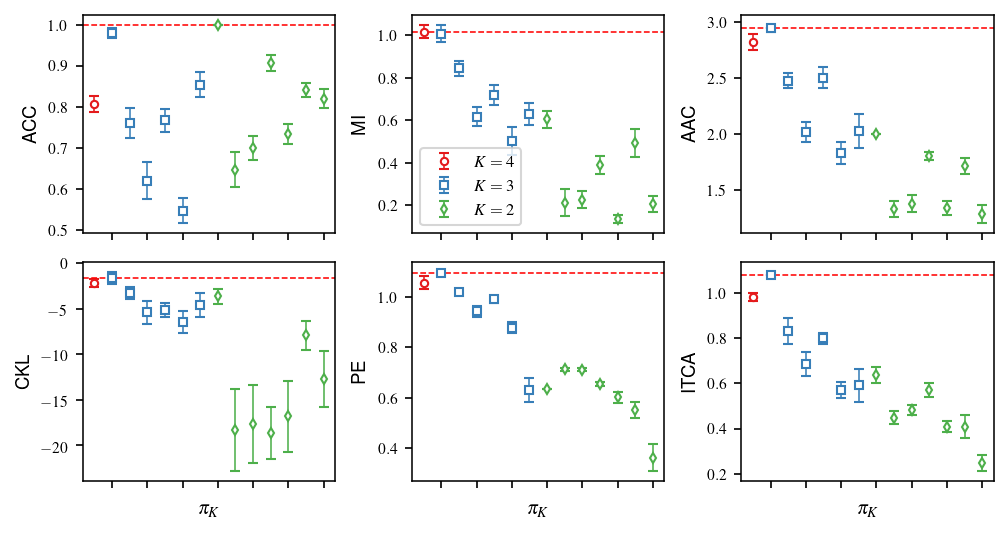

In [65]:
ncols = 3
fig, axes = plt.subplots(2, ncols, sharex=True)
x = np.arange(14)
marker_size = 3.5
factor = 1 / np.sqrt(5)
for ind, name in enumerate(results_cv):
    ax = axes[ind // ncols, ind % ncols]
    measure_mean = list(map(np.mean, results_cv[name]))
    max_measure = np.max(measure_mean)
    measure_std = list(map(np.std, results_cv[name]))
    ax.errorbar(x[0], measure_mean[0], yerr = np.array(measure_std[0]) * factor, linestyle="", marker="o", markersize=marker_size,
                 capsize=2.5, c="#e41a1c", label="$K=4$",  mfc='w')
    ax.errorbar(x[1:7],measure_mean[1:7], yerr = np.array(measure_std[1:7]) * factor, linestyle="", marker="s", markersize=marker_size,
                 capsize=2.5, c="#377eb8", label="$K=3$", mfc='w')
    ax.errorbar(x[7:], measure_mean[7:], yerr = np.array(measure_std[7:]) * factor, linestyle="", marker="d", markersize=marker_size,
                 capsize=2.5, c="#4daf4a", label="$K=2$", mfc='w')
    ax.set_ylabel(name, weight="bold")   
    ax.axhline(max_measure, ls='--', color='r')
    if ind > 2:
        ax.set_xlabel("$\pi_K$")
    ax.set_xticklabels([])
    ax.set_xticks(range(1, 14, 2))
axes[0, 1].legend(fontsize=8, loc="lower left")
fig.set_size_inches(6.75, 3.6)
plt.tight_layout()

## Figure 4: Comparison of clustering-based class combination algorithms and ITCA (using Gaussian kernel SVM as the classification algorithm).

In [78]:
# ==================================== Help functions for generating simulated data =======================================
import warnings
import itertools
from sklearn.metrics import pairwise_distances
from sklearn.manifold import SpectralEmbedding
from sklearn import cluster, datasets, mixture
from sklearn.cluster import KMeans

def make_circles(n_samples = 100, radius = (0, 1.5, 3), noise = 0.1):
    num_classes = len(radius)
    n = int(n_samples / num_classes)
    theta = np.linspace(0, np.pi * 2, n)
    
    X = []
    y = []
    for i in range(num_classes):
        yi = np.ones(n) * i
        Xi = np.zeros([n, 2])
        Xi[:, 0] = radius[i] * np.cos(theta)
        Xi[:, 1] = radius[i] * np.sin(theta)
        Xi += noise * np.random.randn(n, 2)
        X.append(Xi)
        y.append(yi)
    return np.concatenate(X), np.concatenate(y)

def make_moons(n_samples = 100, noise = .1):
    pass

def make_eye(n_samples = 100, noise = .1):
    a = 4
    b = 4
    n = int(n_samples / 3)
    theta = np.linspace(np.pi, np.pi * 2, n)
    X1 = np.zeros([n, 2])
    X1[:, 0] = a * np.cos(theta)
    X1[:, 1] = b * np.sin(theta)
    X1 += noise * np.random.randn(n, 2)
    y1 = np.ones(n) * 0
    X2 = np.random.randn(n, 2) * 0.8
    y2 = np.ones(n) 
    X3 = np.zeros([n, 2])
    X3[:, 0] = np.linspace(-a, a, n) * .3
    X3[:, 1] = - b * 1.1
    X3 += noise * np.random.randn(n, 2)
    y3 = np.ones(n) * 2
    X3[-1, :] = X1[int(n / 2), :]
    X = np.concatenate([X1, X2, X3])
    y = np.concatenate([y1, y2, y3])
    return X, y


def make_moons(n_samples = 100, noise = .1, shift=.3):
    X, y = datasets.make_moons(n_samples=n_samples, noise=.05, random_state=42)
    X1_ = X[y==0, :]
    indices = np.random.rand(X1_.shape[0]) 
    X1 = X1_[indices > 0.5, :]
    y1 = np.ones(X1.shape[0]) * 0
    X2 = X1_[indices < 0.5, :]
    X2[:, 1] += shift
    y2 = np.ones(X2.shape[0]) * 1
    ### 
    X3 = X[y==1, :]
    y3 = np.ones(X3.shape[0]) * 2    
    return np.concatenate([X1, X2, X3]), np.concatenate([y1, y2, y3])

def compute_class_centers(X, y):
    num_classes = len(np.unique(y))
    centers = []
    for i in range(num_classes):
        centers.append(np.mean(X[y==i, :], axis=0))
    return centers

def compute_cluster_wise_dist(X, y, method="single", class_type="ordinal"):
    """
    Compute ordinal cluster-wise distance.
    """
    labels = np.unique(y)
    n_classes = len(labels)
    pdist_res = []
    funcs = {"single": np.min, "average": np.mean, "complete": np.max}
    if class_type == "ordinal":
        for ind in range(n_classes - 1):
            pdist = pairwise_distances(X[y==ind, :], X[y==ind + 1, :])
            pdist_res.append(((ind, ind+1), funcs[method](pdist)))
    elif class_type == "nominal":
        for ind_i, ind_j in itertools.combinations(labels, 2):
            pdist = pairwise_distances(X[y==ind_i, :], X[y==ind_j, :])
            pdist_res.append(((ind_i, ind_j), funcs[method](pdist)))
    return dict(pdist_res)

def combine_i_j(i, j, mapping):
    """
    Combine (merged) class labels i and j in mapping.
        Parameters
        ----------
        i: int
        j: int
        Return
        ------
        next_mapping: bidict
            mapping that combines the class i and j
        
        Example
        -------
        >>mapping = bidict({0:0, 1:1, 2:2})
        >>self.combine_i_j(0, 1, mapping)
        {0:0, 1:0, 2:1}
        """
    next_mapping = dict()
    for key in mapping.inverse:
        if key < j:
            next_mapping.update({e: key for e in mapping.inverse[key]})
        elif key > j:
            next_mapping.update({e: key - 1 for e in mapping.inverse[key]})
        else:
            next_mapping.update({e: i for e in mapping.inverse[key]})
    return bidict(next_mapping)

def herichical_clustering(X, y, k, method="single", class_type="nominal"):
    num_classes = len(np.unique(y))
    path = []
    y_obs = y
    cur_mapping = bidict({i:i for i in range(num_classes)})
    while num_classes > k:
        pdist_res = compute_cluster_wise_dist(X, y_obs, class_type=class_type, method=method)
        i, j = min(pdist_res, key=pdist_res.get)
        cur_mapping = combine_i_j(i, j, cur_mapping)
        num_classes = len(cur_mapping.inverse)
        y_obs = cur_mapping.map(y)
        path.append(cur_mapping)
    return path

def compute_embedding(X, k):
    embedding = SpectralEmbedding(n_components=k)
    X_transformed = embedding.fit_transform(X)
    return X_transformed

def benchmark(X, y, k):
    centers = compute_class_centers(X, y)
    kmeans = KMeans(n_clusters=k, random_state=0).fit(np.array(centers))
    embedding = compute_embedding(X, k)
    sc_centers = compute_class_centers(embedding, y)
    sc = KMeans(n_clusters=k, random_state=0).fit(np.array(sc_centers))
    return {"kmeans": kmeans.labels_,
           "spectral": sc.labels_}

def labels_to_mapping(labels_):
    return bidict({i: labels_[i] for i in range(len(labels_))})


def plot_scatter(ax, X, y_obs, y_true, mapping):
    colors = ['#fbb4ae','#b3cde3','#ccebc5','#decbe4','#fed9a6','#ffffcc']
    num_classes_obs = len(np.unique(y_obs))
    colors_dict = {i:colors[i] for i in range(num_classes_obs)}
    for i in mapping.inverse:
        labels = mapping.inverse[i]
        for label in labels:
            ax.scatter(X[y_obs==label, 0], X[y_obs==label, 1], c=colors_dict[i], s=2.5, alpha=0.25)
    return ax

In [70]:
# ======================== generate simulated data ===============================
num_per_class = 1000
num_classes = 3
blobs = datasets.make_blobs(n_samples=num_per_class * num_classes, random_state=42, centers=3)
noisy_moons = make_moons(n_samples=num_per_class * 3, noise=.05, shift=0.35)
circles = make_circles(n_samples=num_per_class * 3, radius=(0, 2, 3), noise=.2)
noisy_eye = make_eye(n_samples=num_per_class * 3)

C:\Users\admin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


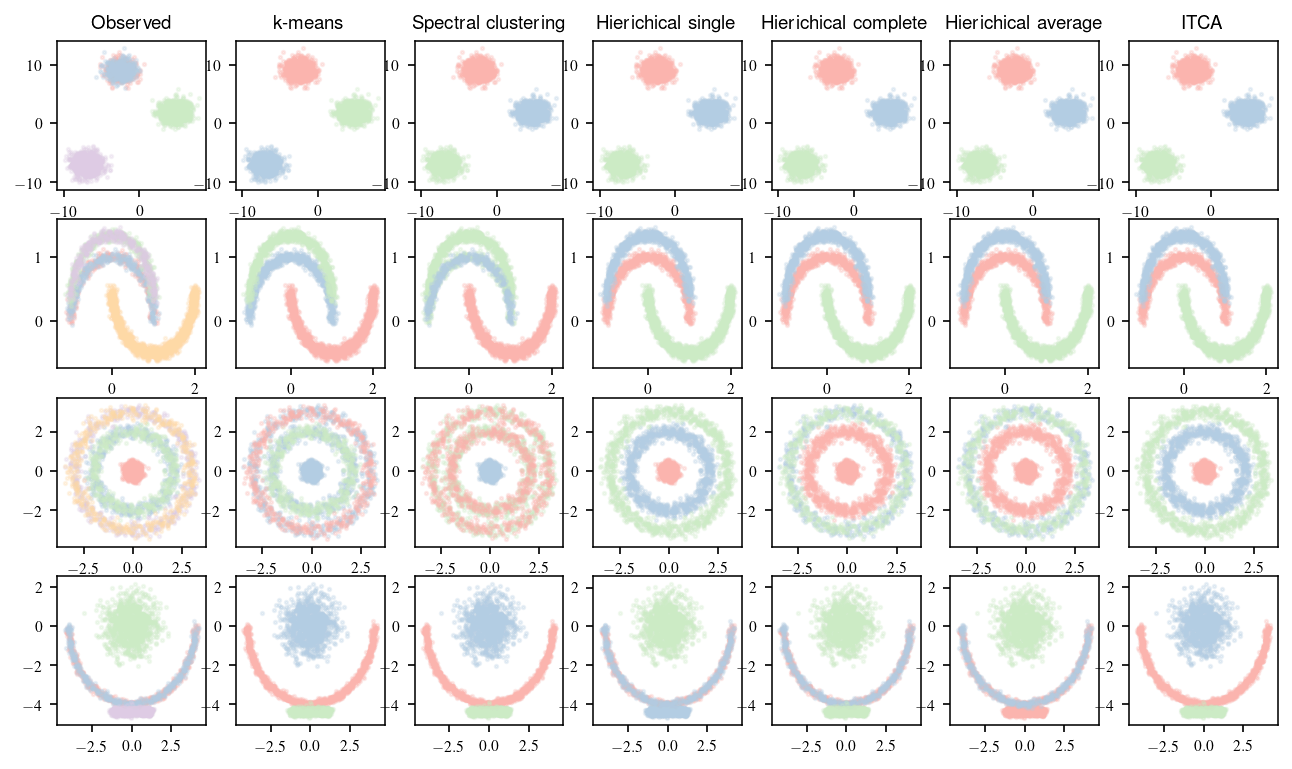

In [79]:
from sklearn.exceptions import DataConversionWarning
from sklearn.svm import SVC

# mappings
mapping_blob = bidict({0:0, 1:0, 2:1, 3:2})
mapping_moon = bidict({0:0, 1:0, 2:1, 3:1, 4:2})
mapping_circle = bidict({0:0, 1:1, 2:1, 3:2, 4:2})
mapping_eye = bidict({0:0, 1:0, 2:1, 3:2})
mappings = [mapping_blob, mapping_moon, mapping_circle, mapping_eye]
num_classes = [3, 3, 3, 3]
# datasets
simulated_datasets = [blobs, noisy_moons, circles, noisy_eye]
nrows = 4
ncols = 7
fig, axes = plt.subplots(nrows, ncols)
width = 10.5
fig.set_size_inches(width, width / ncols * nrows * .95)
plt.set_cmap("Paired")
for ind, dataset in enumerate(simulated_datasets):
    X, y = dataset
    mapping = mappings[ind]
    # generate oberverd labels
    y_obs = mapping.reverse_map(y)
    # plot observed data
    id_mapping = bidict({i:i for i in range(np.max(y_obs) + 1)})
    plot_scatter(axes[ind][0], X, y_obs, y, id_mapping)
    # axes[ind][0].scatter(X[:, 0], X[:, 1], c=y_obs)
    
   
    res = benchmark(X, y_obs,  num_classes[ind])
    # K-means
    kmeans_mapping = labels_to_mapping(res["kmeans"])
    plot_scatter(axes[ind][1], X, y_obs, y, kmeans_mapping)  
    # spectral clustering
    sc_mapping = labels_to_mapping(res["spectral"])
    plot_scatter(axes[ind][2], X, y_obs, y, sc_mapping)    
    # hierical clustering average
    single_path = herichical_clustering(X, y_obs, num_classes[ind], method="single", class_type="nominal")
    single_mapping = single_path[-1]
    plot_scatter(axes[ind][3], X, y_obs, y, single_mapping)
    
    # complete
    complete_path = herichical_clustering(X, y_obs, num_classes[ind], method="complete", class_type="nominal")
    complete_mapping = complete_path[-1]
    plot_scatter(axes[ind][4], X, y_obs, y, complete_mapping)  
    # average
    average_path = herichical_clustering(X, y_obs, num_classes[ind], method="average", class_type="nominal")
    average_mapping = average_path[-1]
    plot_scatter(axes[ind][5], X, y_obs, y, average_mapping)
    # ITCA
    clf = SVC(gamma=2, C=1)
    gs = GreedySearch()
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        gs.search(X, y_obs, clf, kfolds=10)
        itca_mapping = gs.selected.mapping
        plot_scatter(axes[ind][6], X, y_obs, y, itca_mapping)
    if ind == 0:
        axes[0][0].set_title("Observed")
        axes[0][1].set_title("k-means")
        axes[0][2].set_title("Spectral clustering")
        axes[0][3].set_title("Hierichical single")
        axes[0][4].set_title("Hierichical complete") 
        axes[0][5].set_title("Hierichical average")
        axes[0][6].set_title("ITCA")
plt.tight_layout()